In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from scipy import signal
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, Lambda, AveragePooling2D, Softmax, ReLU, Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import time
from math import floor,inf
from sklearn.utils import shuffle
import seaborn as sns

In [2]:
###Tasks to be classified e.g. left hand and right hand MI
labels = ['Left Hand', 'Right Hand']

In [3]:
###Maps labels to numbers starting from 0
def map_labels(label):
    for i in range(len(labels)):
        if label == labels[i]:
            label = i
    return label

In [4]:
###Function to process raw EEG and create training and validation datasets
def create_data(data_folder, filtered, samples, overlap, classes):
    b,a = signal.butter(2, Wn = [48,52], btype = 'bandstop', fs = 250)
    d,c = signal.butter(2, Wn = [4,38], btype = 'bandpass', fs = 250)
    
    data_dir = os.path.join(os.getcwd(),data_folder)

    mi_tasks=classes
    
    directories = {}
    for i in range(len(mi_tasks)):
        directories[mi_tasks[i]] = data_dir + '\\' + mi_tasks[i]

    samples = samples
    overlap = overlap
    unique = floor((1-overlap)*samples)
    x=[]
    y=[]
    all_data = {}
    filtered_data = {}

    for task in mi_tasks:
        all_data[task] = {}
        filtered_data[task] = {}    

    for i in directories:
        folders = os.listdir(directories[i])
        count = 0
        for w in range(len(folders)):
            current_dir = directories[i] + '\\' + folders[w]
            files = os.listdir(current_dir)
            for file in files:
                data = pd.read_csv(current_dir + '\\' + file, header = None)
                eeg_data = data.iloc[1:,1:9]
                if eeg_data.size >= 3250: #rejects trials with recording errors that were short
                    for div in range(int(eeg_data.size//(eeg_data.shape[1]*unique))):
                        if div*unique +samples <= eeg_data.size/eeg_data.shape[1]:
                            all_data[i][count]= eeg_data[div*unique:div*unique + samples]
                            if filtered:
                                to_filter = all_data[i][count]
                                filtered_data=pd.DataFrame(columns = range(0,eeg_data.shape[1]))
                                for chan in range(to_filter.shape[1]):
                                    notch_filtered_chan = signal.filtfilt(b,a,to_filter.iloc[:,chan], padtype='even')
                                    filtered_chan = signal.filtfilt(d,c,notch_filtered_chan, padtype='even')
                                    filtered_data[chan] = filtered_chan
                                x.append(np.transpose(filtered_data.to_numpy()))
                                    
                            else:
                                x.append(np.transpose(all_data[i][count].to_numpy()))
                            
                            y.append(i)
                            count += 1

                else:
                    print('* not accepted *')   #for trials that were too short
                    print(file)
    x=np.array(x)
    x=x.reshape(x.shape[0],x.shape[1],x.shape[2],1)
    y = list(map(map_labels,y))
    x, y = shuffle(x,y, random_state=42)
    return all_data, x, y

In [5]:
###Location of raw EEG trials
train_data_folder = '05to20-08 Active 8chan FPZ Bias'
test_data_folder = '23&24-08 Active 8chan FPZ Bias'

In [6]:
###Create filtered 2 sec trials with 90% overlap
train_data, x_train, y_train = create_data(train_data_folder, True, 500, 0.90, labels)
test_data, x_test, y_test = create_data(test_data_folder, True, 500, 0.90, labels)
print(x_train.shape)
print(x_test.shape)

(4336, 8, 500, 1)
(1441, 8, 500, 1)


In [10]:
###Class labels one-hot encoded
y_cat_train = to_categorical(y_train)
y_cat_test = to_categorical(y_test)

In [11]:
###Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 476, 40)        1040      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 476, 40)        12840     
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 476, 40)        160       
_________________________________________________________________
lambda (Lambda)              (None, 1, 476, 40)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 27, 40)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1, 27, 40)         0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 27, 40)         0

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[409 312]
 [351 369]]
46/46 [==============================] - 0s 3ms/step - loss: 0.7311 - accuracy: 0.5399
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 8, 476, 40)        1040      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 476, 40)        12840     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 476, 40)        160       
_________________________________________________________________
lambda_2 (Lambda)            (None, 1, 476, 40)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 27, 40)         0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 1, 27, 40)         0         
__________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

   Left Hand       0.52      0.51      0.52       721
  Right Hand       0.52      0.53      0.53       720

    accuracy                           0.52      1441
   macro avg       0.52      0.52      0.52      1441
weighted avg       0.52      0.52      0.52      1441

[[368 353]
 [338 382]]
46/46 [==============================] - 0s 3ms/step - loss: 0.7246 - accuracy: 0.5205
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 8, 476, 40)        1040      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 476, 40)        12840     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 476, 40)        160       
_________________________________________________________________
lambda_4 (Lam

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 0s 3ms/step - loss: 0.7052 - accuracy: 0.5531
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 8, 476, 40)        1040      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 476, 40)        12840     
_________________________________________________________________
batch_normalization_3 (Batch (None, 1, 476, 40)        160       
_________________________________________________________________
lambda_6 (Lambda)            (None, 1, 476, 40)        0         
_________________________________________________________________
average_pooling2d_3 (Average (None, 1, 27, 40)         0         
_________________________________________________________________
lambda_7 (Lambda)            (None, 1, 27, 40)         0         
_________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 0s 3ms/step - loss: 0.7321 - accuracy: 0.5219
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 8, 476, 40)        1040      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 476, 40)        12840     
_________________________________________________________________
batch_normalization_4 (Batch (None, 1, 476, 40)        160       
_________________________________________________________________
lambda_8 (Lambda)            (None, 1, 476, 40)        0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 1, 27, 40)         0         
_________________________________________________________________
lambda_9 (Lambda)            (None, 1, 27, 40)         0         
_________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 0s 3ms/step - loss: 0.7189 - accuracy: 0.5101
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 8, 476, 40)        1040      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 476, 40)        12840     
_________________________________________________________________
batch_normalization_5 (Batch (None, 1, 476, 40)        160       
_________________________________________________________________
lambda_10 (Lambda)           (None, 1, 476, 40)        0         
_________________________________________________________________
average_pooling2d_5 (Average (None, 1, 27, 40)         0         
_________________________________________________________________
lambda_11 (Lambda)           (None, 1, 27, 40)         0         
_________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 0s 3ms/step - loss: 0.7102 - accuracy: 0.5711
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 8, 476, 40)        1040      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 1, 476, 40)        12840     
_________________________________________________________________
batch_normalization_6 (Batch (None, 1, 476, 40)        160       
_________________________________________________________________
lambda_12 (Lambda)           (None, 1, 476, 40)        0         
_________________________________________________________________
average_pooling2d_6 (Average (None, 1, 27, 40)         0         
_________________________________________________________________
lambda_13 (Lambda)           (None, 1, 27, 40)         0         
_________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 0s 3ms/step - loss: 0.7302 - accuracy: 0.5309
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 8, 476, 40)        1040      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 476, 40)        12840     
_________________________________________________________________
batch_normalization_7 (Batch (None, 1, 476, 40)        160       
_________________________________________________________________
lambda_14 (Lambda)           (None, 1, 476, 40)        0         
_________________________________________________________________
average_pooling2d_7 (Average (None, 1, 27, 40)         0         
_________________________________________________________________
lambda_15 (Lambda)           (None, 1, 27, 40)         0         
_________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 0s 3ms/step - loss: 0.7142 - accuracy: 0.5302
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 8, 476, 40)        1040      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 1, 476, 40)        12840     
_________________________________________________________________
batch_normalization_8 (Batch (None, 1, 476, 40)        160       
_________________________________________________________________
lambda_16 (Lambda)           (None, 1, 476, 40)        0         
_________________________________________________________________
average_pooling2d_8 (Average (None, 1, 27, 40)         0         
_________________________________________________________________
lambda_17 (Lambda)           (None, 1, 27, 40)         0         
_________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 0s 3ms/step - loss: 0.7194 - accuracy: 0.5253
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 8, 476, 40)        1040      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 476, 40)        12840     
_________________________________________________________________
batch_normalization_9 (Batch (None, 1, 476, 40)        160       
_________________________________________________________________
lambda_18 (Lambda)           (None, 1, 476, 40)        0         
_________________________________________________________________
average_pooling2d_9 (Average (None, 1, 27, 40)         0         
_________________________________________________________________
lambda_19 (Lambda)           (None, 1, 27, 40)         0         
_________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 0s 3ms/step - loss: 0.7179 - accuracy: 0.5142


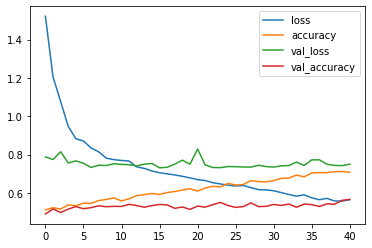

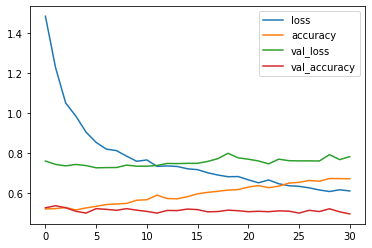

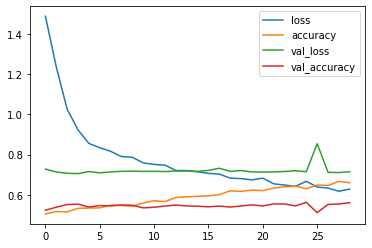

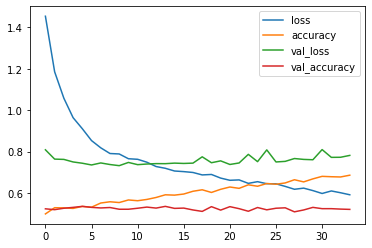

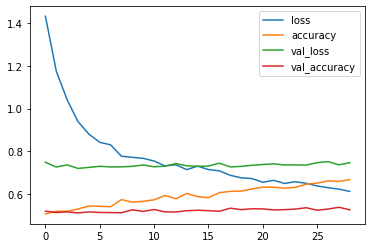

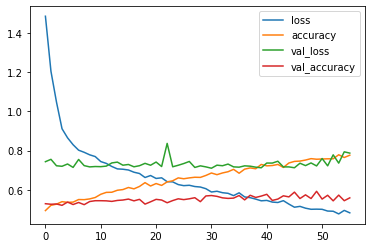

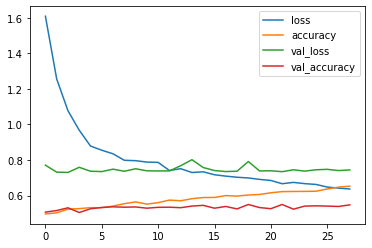

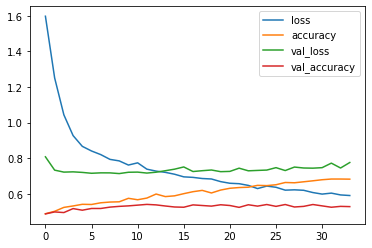

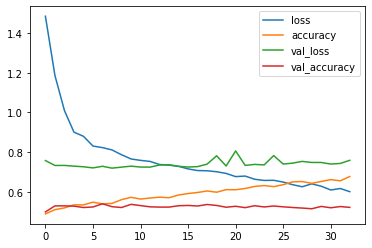

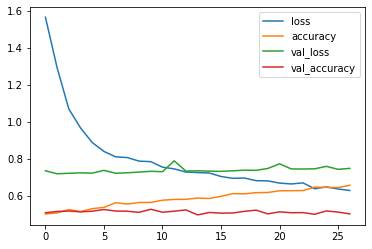

In [12]:
####Loop to get best models#####
best_accuracy = 0
accuracies = []
for session in range(10):   #models trained 10 times
    shallow = True

    ####  MODEL BUILDER  ####

    model = Sequential()
    if shallow:
        model.add(Conv2D(filters=40, kernel_size=(1,25), input_shape=(x_train.shape[1],x_train.shape[2],1))) #, activation = 'relu'))
        model.add(Conv2D(filters=40, kernel_size=(8,1), activation = 'elu'))
        model.add(BatchNormalization(momentum=0.1, epsilon = 1e-05))
        model.add(Lambda(lambda x: x**2))
        model.add(AveragePooling2D(pool_size=(1,75),strides=15))

        model.add(Lambda(lambda x: tf.math.log(tf.clip_by_value(x, 1e-6, inf))))

        model.add(Dropout(0.5))

        '''model.add(Conv2D(filters=4, kernel_size=(1,69))) #, activation = 'relu'))       

        model.add(Softmax())

        model.add(Lambda(lambda x: tf.squeeze(x, [1,2])))'''   #Equivalent to flattening the output which was used instead
    else:   #Deep CNN from Schirrmeister et al.
        model.add(Conv2D(filters=25, kernel_size=(1,10), input_shape=(x_train.shape[1],x_train.shape[2],1))) #, activation = 'relu'))
        model.add(Conv2D(filters=25, kernel_size=(13,1), activation = 'elu'))
        model.add(BatchNormalization(momentum=0.1, epsilon = 1e-05))

        model.add(MaxPool2D(pool_size=(1,3),strides=3))
        model.add(Dropout(0.5))
        model.add(Conv2D(filters=50, kernel_size=(1,10), activation='elu'))
        model.add(BatchNormalization(momentum=0.1, epsilon = 1e-05))

        model.add(MaxPool2D(pool_size=(1,3),strides=3))
        model.add(Dropout(0.5))
        model.add(Conv2D(filters=100, kernel_size=(1,10), activation='elu'))
        model.add(BatchNormalization(momentum=0.1, epsilon = 1e-05))

        model.add(MaxPool2D(pool_size=(1,3),strides=3))
        model.add(Dropout(0.5))
        model.add(Conv2D(filters=200, kernel_size=(1,10), activation='elu'))
        model.add(BatchNormalization(momentum=0.1, epsilon = 1e-05))
        model.add(MaxPool2D(pool_size=(1,3),strides=3))


    model.add(Flatten())

    if len(labels) <= 2:   #binary
        act_fn = 'sigmoid'
        loss_fn = 'binary_crossentropy'
    else:    #Multiclass
        act_fn = 'softmax'
        loss_fn = 'categorical_crossentropy'
    
    model.add(Dense(len(labels), activation = act_fn))

    adam = tf.keras.optimizers.Adam(learning_rate=0.0001)  #weight optimiser
    
    model.compile(loss = loss_fn, optimizer=adam, metrics=['accuracy'], )  #other metrics at keras.io/metrics

    model.summary()
    
    #Model training

    model.fit(x_train,y_cat_train, epochs = 400, validation_data=(x_test,y_cat_test), callbacks = [early_stop], verbose=2)
    
    metrics = pd.DataFrame(model.history.history)
    metrics.plot()

    predictions = model.predict_classes(x_test)

    print(classification_report(y_test,predictions, target_names=labels))

    print(confusion_matrix(y_test,predictions))
    
    perf = model.evaluate(x_test, y_cat_test)
    accuracies.append(perf[1])
    #Compares model accuracies to identify best model
    if perf[1] > best_accuracy:
        best_accuracy = perf[1]
        best_model = model
    

In [13]:
best_accuracy

0.57113116979599

In [14]:
best_predictions = best_model.predict_classes(x_test)
#Classification report and confusion matrix of best model
print(classification_report(y_test,best_predictions, target_names=labels, digits =3))
conf = confusion_matrix(y_test,best_predictions)
print(conf)

              precision    recall  f1-score   support

   Left Hand      0.570     0.580     0.575       721
  Right Hand      0.572     0.562     0.567       720

    accuracy                          0.571      1441
   macro avg      0.571     0.571     0.571      1441
weighted avg      0.571     0.571     0.571      1441

[[418 303]
 [315 405]]


In [15]:
###Evaluates loss and accuracy of best model
best_model.evaluate(x_test, y_cat_test)

46/46 [==============================] - 0s 3ms/step - loss: 0.7102 - accuracy: 0.5711


[0.7101943492889404, 0.57113116979599]

In [16]:
#Accuracies of the 10 models trained
accuracies

[0.5399028658866882,
 0.5204718708992004,
 0.5530881285667419,
 0.5218598246574402,
 0.5100624561309814,
 0.57113116979599,
 0.5308813452720642,
 0.5301873683929443,
 0.5253296494483948,
 0.5142262578010559]

In [17]:
#Confusion matrix labels
group_counts = ['{0:0.0f}'.format(value) for value in
                conf.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     conf.flatten()/np.sum(conf)]
conf_labels = [f'{v1}\n\n{v2}' for v1, v2 in
          zip(group_counts,group_percentages)]
conf_labels = np.asarray(conf_labels).reshape(conf.shape)

In [18]:
conf_labels

array([['418\n\n29.01%', '303\n\n21.03%'],
       ['315\n\n21.86%', '405\n\n28.11%']], dtype='<U11')

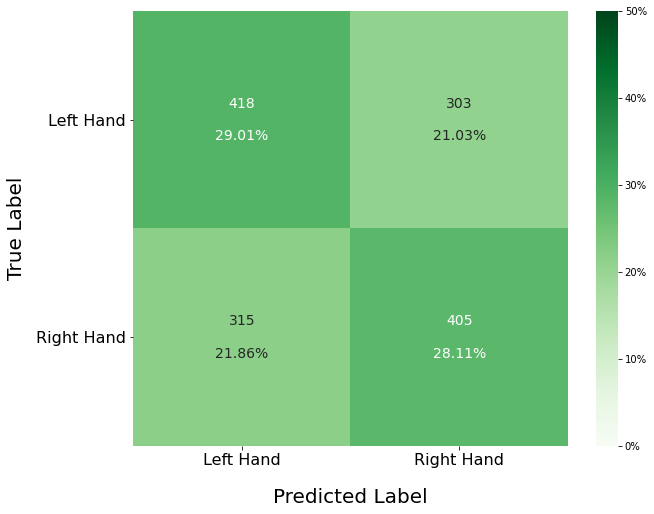

In [19]:
###Confusion matrix plotter
from matplotlib.ticker import PercentFormatter
fig, ax = plt.subplots(figsize=(10,8))
confusion = sns.heatmap(conf/np.sum(conf), annot=conf_labels, annot_kws={'fontsize':14},vmin=0, vmax=1/len(labels), 
            fmt='', cmap='Greens', xticklabels=labels,yticklabels=labels, square=True, ax=ax)
confusion.set_xticklabels(labels, fontsize=16)
confusion.set_yticklabels(labels, fontsize=16, rotation=0)
confusion.set_ylabel('True Label', fontsize=20, labelpad=10)
confusion.set_xlabel('Predicted Label', fontsize=20, labelpad=20)
#confusion.set_title('Confusion Matrix', fontsize=22)  # for title (was not used)
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 0))
plt.show()

In [129]:
os.mkdir('Confusion Matrices')

In [20]:
#Save confusion matrix
fig.savefig('Confusion Matrices\\' + '2classLHRHMIDefault.png', bbox_inches='tight')

In [21]:
#Save best CNN model
best_model.save('Best Models\\' + '2classLHRHMI-Active8chanfpzbias 05to20-08 train 23&24-08 test-57,1%acc.h5')